In [50]:
from cartesio_planning import planning
from cartesio_planning import validity_check
from cartesio_planning import visual_tools
import numpy as np
import scipy.linalg as la
import yaml
import moveit_msgs.msg 
import rospy
import StringIO
from xbot_interface import xbot_interface as xbot
from xbot_interface import config_options as co
from cartesian_interface.pyci_all import *
import cartesian_interface.roscpp_utils as roscpp

# We need to initialize roscpp (underlying code is in C++!)
cpp_argv = []
if not roscpp.init('teleop_example', cpp_argv):
    print 'Unable to initialize roscpp node!'

Unable to initialize roscpp node!


In [51]:
# get robot description from param server
urdf = rospy.get_param('robot_description')
srdf = rospy.get_param('robot_description_semantic')

# make xbot model
opt = co.ConfigOptions()
opt.set_urdf(urdf)
opt.set_srdf(srdf)
opt.generate_jidmap()
opt.set_bool_parameter('is_model_floating_base', False)
opt.set_string_parameter('model_type', 'RBDL')

model = xbot.ModelInterface(opt)

# define joint range
qmin = np.full(model.getJointNum(), -2.0)
qmax = -qmin
yaml_options = '' # leave default options

# create planner
planner = planning.OmplPlanner(qmin, qmax, yaml_options)

In [52]:
# define planning parameters
start = [0, 1, 1, 0, 0]
goal = [-1, -1, -1, 1, 1]
threshold = 0.0

# make planning scene
ps = validity_check.PlanningSceneWrapper(model)
ps.startMonitor() # listen to topics / publish planning scene for visualization
ps.startGetPlanningSceneServer()  # advertise get_planning_scene srv for rviz

# add a box and two spheres to the planning scene
ps.addBox('box', [0.1, 0.8, 0.1], Affine3(pos=[0.3, 0.2, 0.5]))
ps.addSphere('sphere_1', 0.3, Affine3(pos=[0.0, 0.4, 0.7]))
ps.addSphere('sphere_2', 0.2, Affine3(pos=[0.2, -0.4, 0.5]))

In [53]:
# our validity checker checks for collisions
def validity_checker(q):
    model.setJointPosition(q)
    model.update()
    ps.update()
    return not ps.checkCollisions()

In [54]:
# Check start state is valid
print 'Start state valid: {}'.format(validity_checker(start))
print ps.getCollidingLinks()

# Publish it to a marker array
start_viz = visual_tools.RobotViz(model, '/teleop_example/start', color=[0, 0, 1, 0.5])
start_viz.publishMarkers(ps.getCollidingLinks())

Start state valid: True
[]


In [55]:
# Same for goal state...
print 'Goal state valid: {}'.format(validity_checker(goal))
print ps.getCollidingLinks()
goal_viz = visual_tools.RobotViz(model, '/teleop_example/goal', color=[0, 1, 0, 0.5])
goal_viz.publishMarkers(ps.getCollidingLinks())

Goal state valid: True
[]


In [56]:
# Execute planner
planner_type = 'RRTstar'
timeout = 3.0

planner.setStartAndGoalStates(start, goal, threshold)
planner.setStateValidityPredicate(validity_checker)
success = planner.solve(timeout, planner_type)

print 'Planner output : {}'.format(success)

solution = np.array(planner.getSolutionPath()).transpose()

Planner output : True


In [57]:
# Plot solution
%matplotlib inline
import matplotlib.pyplot as plt

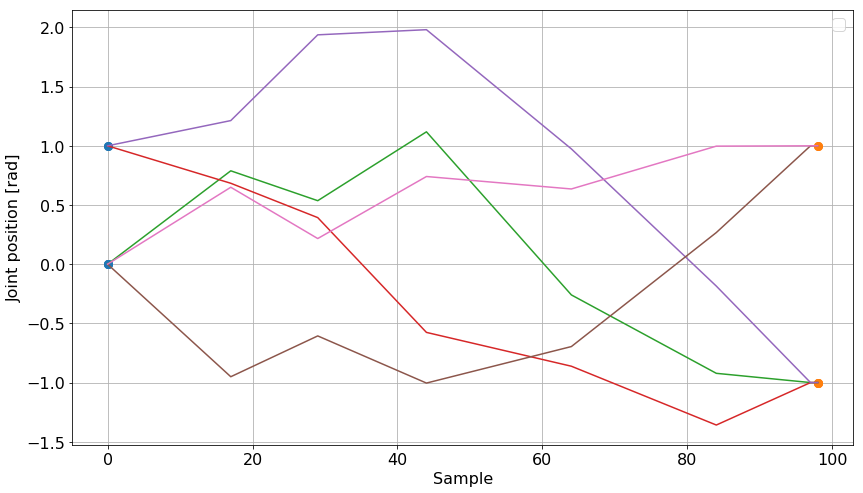

In [58]:
plt.rcParams.update({'figure.figsize': [14, 8],
                     'font.size': 16})

plt.plot(np.full_like(start, 0), start, '.', markersize=16)
plt.plot(np.full_like(goal, solution.shape[1]-1), goal, '.', markersize=16)
plt.plot(solution.transpose(), '-')
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Joint position [rad]')
plt.legend()

In [60]:
# Play solution a number of times..
viz = visual_tools.RobotViz(model, '/teleop_example/solution')

ntimes = 10
duration = 3.0
dt = duration/solution.shape[1]

for _ in range(ntimes):
    
    for i in range(solution.shape[1]):
        
        q = solution[:, i]
        model.setJointPosition(q)
        model.update()
        viz.publishMarkers()
        rospy.sleep(dt)